In [27]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [28]:
paths = ['img/']


In [29]:
def imshow(img):
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    ax.imshow(img, cmap="gray")

In [32]:
possible_labels = os.listdir(os.path.join(paths[0]))
possible_labels.pop(0)
possible_labels

['closed', 'open']

In [34]:
data = []
for i, path in enumerate(paths):
    for label_int, label_string in enumerate(possible_labels):
        filenames = glob.glob(path + label_string + '/*.jpg')
        for filename in filenames:
            img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
            data.append([label_int, cv.resize(img, (224,224))])
print(len(data))

3402


In [36]:
import random
random.Random(0).shuffle(data)

x_train = []
y_train = []
x_test = []
y_test = []

for i, sample in enumerate(data):
    label, img = sample[0], sample[1]
    if i <= 0.7 * len(data):
        x_train.append(img)
        y_train.append(label)
    else:
        x_test.append(img)
        y_test.append(label)

x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [37]:
x_train = x_train/255
x_test = x_test/255

In [38]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [39]:
print(x_train.shape)
print(x_test.shape)

(2382, 224, 224)
(1020, 224, 224)


In [40]:
print(y_train.shape)
print(y_test.shape)

(2382, 2)
(1020, 2)


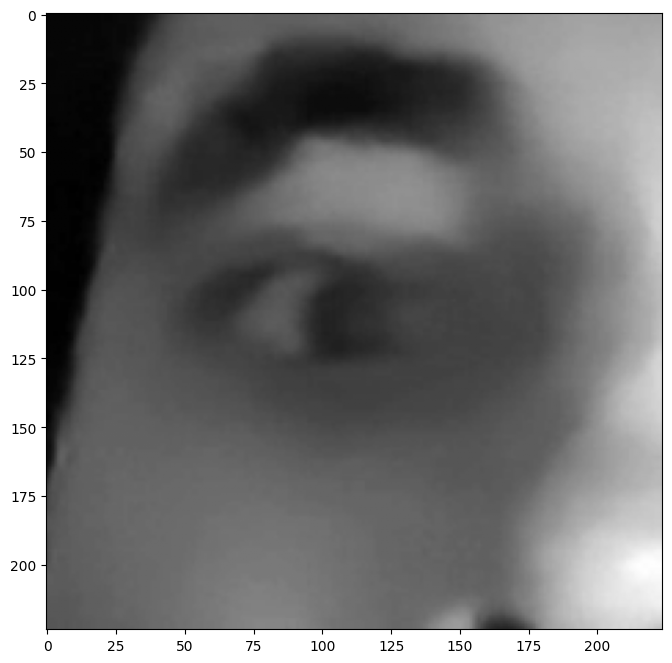

In [41]:
imshow(x_train[0])

# Red neuronal

In [ ]:
def model():
    model = Sequential()
    model.add(Conv2D(32,(3,3), input_shape=(224, 224, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Flatten())
    model.add(Dense(30, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
callback = EarlyStopping(monitor='loss', patience=3)

In [43]:
model = model()
model.summary()

/Users/aratt/Documents/workspace/dp+v/vision/visionEnv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │     1,244,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            62 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253,820 (4.78 MB)

 Trainable params: 1,253,820 (4.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(x_train, y_train, epochs=200, batch_size=64)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.6096 - loss: 0.6963
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.9147 - loss: 0.2919
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.9357 - loss: 0.1849
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.9549 - loss: 0.1322
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.9766 - loss: 0.0886
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.9810 - loss: 0.0597
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.9826 - loss: 0.0534
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.9831 - loss: 0.0504
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - accuracy: 0.9848 - loss: 0.0420
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 284ms/step - accuracy: 0.9843 - loss: 0.0502


In [45]:
model.evaluate(x_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9902 - loss: 0.0426


[0.03839481249451637, 0.9872549176216125]

In [48]:
prediction = model.predict(x_test[1:2])
prediction_label = prediction.argmax()
print(f'Prediction: {prediction_label}')
print(f'Etiqueta real: {y_test[1].argmax()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: 0
Etiqueta real: 0


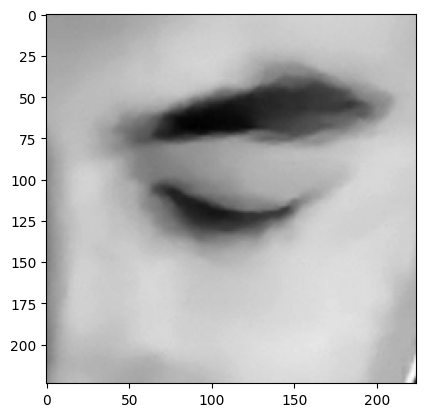

In [49]:
plt.imshow(x_test[1], cmap='gray')

In [50]:
model.save("models/open-closed-eyes-v3.h5")